Some of the code in this notebook has been modified from:

https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_07.ipynb

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from patsy import dmatrix

### Code 7.1

In [2]:
sppnames = ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens']
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]

df = pd.DataFrame({'species': sppnames, 'brain': brainvolcc, 'mass': masskg})
df

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


In [3]:
df[['brain', 'mass']].corr()

,brain,mass
brain,1.000000,0.700113
mass,0.700113,1.000000


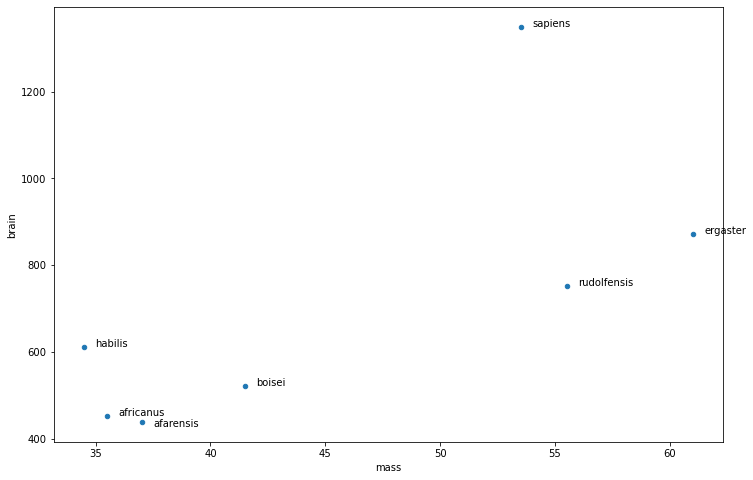

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
df.plot(x='mass', y='brain', kind='scatter', ax=ax)

for k, row in df.iterrows():
    y_offset = 0.5
    x_offset = 0.5
    
    if row['species'] == 'afarensis':
        y_offset = -10.0
    
    ax.annotate(row['species'], xy=(row['mass'] + x_offset, row['brain'] + y_offset))

### Code 7.2

In [5]:
df['mass_std'] = (df['mass'] - df['mass'].mean()) / df['mass'].std()
df['brain_std'] = df['brain'] / df['brain'].max()

In [6]:
df[['mass_std', 'brain_std']].describe([0.055, 0.945])

,mass_std,brain_std
count,7.000000e+00,7.000000
mean,3.172066e-17,0.528677
std,1.000000e+00,0.238702
min,-1.008722e+00,0.324444
5.5%,-9.784600e-01,0.327867
50%,-3.668079e-01,0.453333
94.5%,1.254941e+00,0.882911
max,1.421380e+00,1.000000


## Model 1

$$
\begin{array}
~b_i     & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i   & = \alpha + \beta \cdot m_i \\
\alpha  & \sim \text{Normal}(0.5, 1) \\
\beta   & \sim \text{Normal}(0, 10) \\
\sigma  & \sim \text{Log-Normal}(0, 1) \\
\end{array}
$$

### Code 7.3 

In [7]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=df).fit()

# summary with 89% CI
m_7_1.summary(alpha=0.11)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Thu, 11 Feb 2021   Prob (F-statistic):             0.0798
Time:                        09:35:17   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.055      0.945]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.392       0.666
mass_std       0.1671      0.076      2.192      0.080       0.019       0.315
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
def calculate_r2_score(model, actual_data = df['brain_std']):
    return 1 - model.resid.var() / actual_data.var()

In [9]:
calculate_r2_score(m_7_1)

0.490158047949084

## More Complex Models with Higher Degree Polynomials

### Code 7.7

**Note on Patsy Formulas**

To perform some arithmetic inside the formula object, one can hide it from the Patsy parser by putting it inside a function call. To make this more convenient, Patsy provides a builtin function `I()` that simply returns its input. The name `I` stands for the Identity function.

In [10]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=df).fit()

m_7_2.summary(alpha=0.11)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     2.310
Date:                Thu, 11 Feb 2021   Prob (F-statistic):              0.215
Time:                        09:35:17   Log-Likelihood:                 3.3223
No. Observations:                   7   AIC:                           -0.6445
Df Residuals:                       4   BIC:                           -0.8068
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.055      0.945]
------------------------------------------------------------------------------------
Intercept            0.6142      0.155      3.950      0.017       0.296       0.933
mass_std             0.1957      0.093      2.101      0.104       0.005       0.386
I(mass_std ** 2)    -0.0998      0.159     -0.629      0.564      -0.425       0.225
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.479
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.016
Skew:                           0.901   Prob(JB):                        0.602
Kurtosis:                       2.514   Cond. No.                         4.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Code 7.8 and 7.9

In [11]:
m_7_3 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", 
                data=df).fit()
m_7_4 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)", 
                data=df).fit()
m_7_5 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)", 
                data=df).fit()
m_7_6 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)", 
                data=df).fit()